In [1]:
import pandas as pd
import numpy as np
import glob
import os

In [10]:
PROBLEM = 'F7'
RESULTS_DIRS = ['results_single', 'results_proposed']

In [11]:
dfs = []
for dir_name in RESULTS_DIRS:
    pattern = os.path.join(dir_name, f'{PROBLEM}_*.csv')
    files = sorted(glob.glob(pattern))
    for file in files:
        print(f"Loading {file}")
        dfs.append(pd.read_csv(file, names=["time", "objective"]))

print(f"Loaded {len(dfs)} files for {PROBLEM}")

Loading results_single/F7_run1.csv
Loading results_single/F7_run2.csv
Loading results_single/F7_run3.csv
Loading results_proposed/F7_run1.csv
Loading results_proposed/F7_run10.csv
Loading results_proposed/F7_run2.csv
Loading results_proposed/F7_run3.csv
Loading results_proposed/F7_run4.csv
Loading results_proposed/F7_run5.csv
Loading results_proposed/F7_run6.csv
Loading results_proposed/F7_run7.csv
Loading results_proposed/F7_run8.csv
Loading results_proposed/F7_run9.csv
Loaded 13 files for F7


In [12]:
# Separate single and proposed files based on directory
dfs_single = []
dfs_proposed = []

for dir_name in RESULTS_DIRS:
    pattern = os.path.join(dir_name, f'{PROBLEM}_*.csv')
    files = sorted(glob.glob(pattern))
    for file in files:
        print(f"Loading {file}")
        df = pd.read_csv(file, names=["time", "objective"])
        if 'single' in dir_name:
            dfs_single.append(df)
        else:
            dfs_proposed.append(df)

print(f"Loaded {len(dfs_single)} single files and {len(dfs_proposed)} proposed files for {PROBLEM}")

Loading results_single/F7_run1.csv
Loading results_single/F7_run2.csv
Loading results_single/F7_run3.csv
Loading results_proposed/F7_run1.csv
Loading results_proposed/F7_run10.csv
Loading results_proposed/F7_run2.csv
Loading results_proposed/F7_run3.csv
Loading results_proposed/F7_run4.csv
Loading results_proposed/F7_run5.csv
Loading results_proposed/F7_run6.csv
Loading results_proposed/F7_run7.csv
Loading results_proposed/F7_run8.csv
Loading results_proposed/F7_run9.csv
Loaded 3 single files and 10 proposed files for F7


In [13]:
# Process SINGLE files: replace timestamp with 0, 5, 10, ...
dfs_single_processed = []
for df in dfs_single:
    df_copy = df.copy()
    df_copy['time'] = np.arange(len(df_copy)) * 5  # 0, 5, 10, 15, ...
    dfs_single_processed.append(df_copy)
    print(f"Single file: {len(df_copy)} rows, time range [0, {df_copy['time'].iloc[-1]}]")

# Find max length across all single files to use longest duration as target
max_len_single = max(len(df) for df in dfs_single_processed)
print(f"Max length across single files: {max_len_single}")

# Pad all single files to max_len by repeating the last value
dfs_single_padded = []
for df in dfs_single_processed:
    df_padded = df.copy()
    if len(df_padded) < max_len_single:
        last_obj = df_padded['objective'].iloc[-1]
        num_pad = max_len_single - len(df_padded)
        # Continue time values from where the file ended
        start_idx = len(df_padded)
        pad_times = np.arange(start_idx, max_len_single) * 5
        pad_df = pd.DataFrame({
            'time': pad_times,
            'objective': [last_obj] * num_pad
        })
        df_padded = pd.concat([df_padded, pad_df], ignore_index=True)
    dfs_single_padded.append(df_padded)

# Compute average across all padded single files
single_avg = pd.DataFrame({
    'time': dfs_single_padded[0]['time'],
    'objective': np.mean([df['objective'].values for df in dfs_single_padded], axis=0)
})

# Save single file average
single_avg.to_csv(f'{PROBLEM}_single_avg.csv', index=False, header=False)
print(f"Saved {PROBLEM}_single_avg.csv with {len(single_avg)} rows")
single_avg.head()

Single file: 36 rows, time range [0, 175]
Single file: 35 rows, time range [0, 170]
Single file: 35 rows, time range [0, 170]
Max length across single files: 36
Saved F7_single_avg.csv with 36 rows


,time,objective
0,0,5629.189339
1,5,3902.206562
2,10,2090.534004
3,15,2038.165231
4,20,2029.579323


In [14]:
# Process PROPOSED files: remove high fitness plateau, reset timestamps, then average
dfs_proposed_processed = []

for idx, df in enumerate(dfs_proposed):
    df_copy = df.copy()
    
    # Find the high fitness plateau: look for the first significant drop in objective
    # Calculate the change in objective between consecutive rows
    obj_change = df_copy['objective'].diff().fillna(0)
    
    # Find the first row where objective decreases (improvement in minimization)
    # by looking for where cumulative change becomes more negative
    cumsum_change = obj_change.cumsum()
    
    # Find the first index where we see clear improvement (below initial value)
    initial_obj = df_copy['objective'].iloc[0]
    
    # Find where objective first drops below initial value
    improving_mask = df_copy['objective'] < initial_obj
    if improving_mask.any():
        first_improve_idx = improving_mask.idxmax()  # First True index
    else:
        # If no improvement, find where the steepest drop occurs
        first_improve_idx = obj_change.idxmin()
    
    # Remove initial plateau
    df_cleaned = df_copy.iloc[first_improve_idx:].reset_index(drop=True)
    
    # Reset timestamps to 0, 5, 10, ...
    df_cleaned['time'] = np.arange(len(df_cleaned)) * 5
    
    dfs_proposed_processed.append(df_cleaned)
    print(f"Proposed file {idx}: removed {first_improve_idx} rows (plateau), {len(df_cleaned)} rows remaining, time range [0, {df_cleaned['time'].iloc[-1]}]")

# Find min length across all proposed files for alignment
min_len_proposed = min(len(df) for df in dfs_proposed_processed)
print(f"Min length across proposed files: {min_len_proposed}")

# Truncate all proposed files to min_len and compute average
dfs_proposed_truncated = [df.iloc[:min_len_proposed] for df in dfs_proposed_processed]
proposed_avg = pd.DataFrame({
    'time': dfs_proposed_truncated[0]['time'],
    'objective': np.mean([df['objective'].values for df in dfs_proposed_truncated], axis=0)
})

# Save proposed file average
proposed_avg.to_csv(f'{PROBLEM}_prop_avg.csv', index=False, header=False)
print(f"Saved {PROBLEM}_prop_avg.csv with {len(proposed_avg)} rows")
proposed_avg.head()

Proposed file 0: removed 6 rows (plateau), 34 rows remaining, time range [0, 165]
Proposed file 1: removed 10 rows (plateau), 30 rows remaining, time range [0, 145]
Proposed file 2: removed 11 rows (plateau), 29 rows remaining, time range [0, 140]
Proposed file 3: removed 9 rows (plateau), 31 rows remaining, time range [0, 150]
Proposed file 4: removed 10 rows (plateau), 30 rows remaining, time range [0, 145]
Proposed file 5: removed 10 rows (plateau), 30 rows remaining, time range [0, 145]
Proposed file 6: removed 10 rows (plateau), 30 rows remaining, time range [0, 145]
Proposed file 7: removed 10 rows (plateau), 30 rows remaining, time range [0, 145]
Proposed file 8: removed 10 rows (plateau), 30 rows remaining, time range [0, 145]
Proposed file 9: removed 10 rows (plateau), 30 rows remaining, time range [0, 145]
Min length across proposed files: 29
Saved F7_prop_avg.csv with 29 rows


,time,objective
0,0,5271.71704
1,5,4068.09862
2,10,3373.31592
3,15,3101.98595
4,20,2893.34948


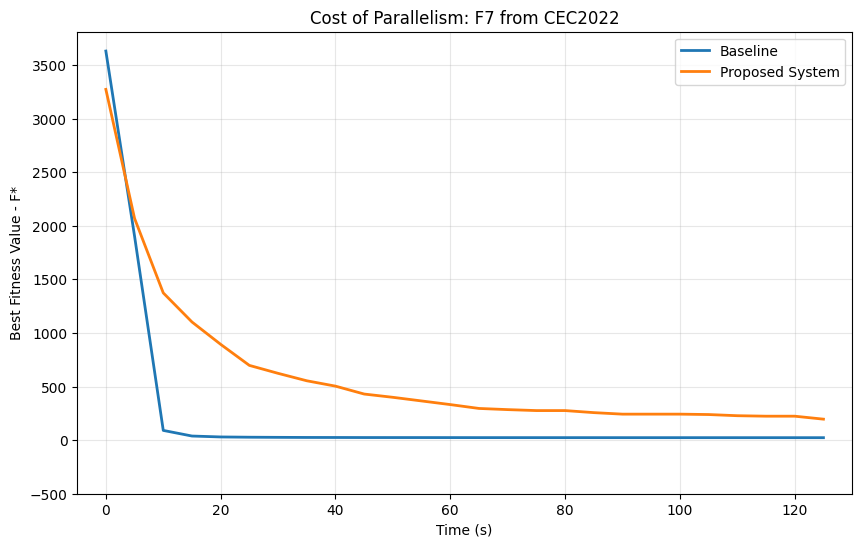

In [15]:
# Visualize both averages together (truncated to 125 seconds)
import matplotlib.pyplot as plt
from opfunu.cec_based import cec2022

# Get the global optimum for the current problem
func_map = {
    'F7': cec2022.F72022(ndim=20),
    'F11': cec2022.F112022(ndim=20),
    'F12': cec2022.F122022(ndim=20),
}
cec_func = func_map[PROBLEM]
f_global = cec_func.f_global

max_time = 125

# Filter data to max_time and subtract global optimum
single_plot = single_avg[single_avg['time'] <= max_time].copy()
proposed_plot = proposed_avg[proposed_avg['time'] <= max_time].copy()

single_plot['objective'] = single_plot['objective'] - f_global
proposed_plot['objective'] = proposed_plot['objective'] - f_global

plt.figure(figsize=(10, 6))
plt.plot(single_plot['time'], single_plot['objective'], label='Baseline', linewidth=2)
plt.plot(proposed_plot['time'], proposed_plot['objective'], label='Proposed System', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Best Fitness Value - F*')
plt.title(f'Cost of Parallelism: {PROBLEM} from CEC2022')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-5, max_time+5)
plt.ylim(bottom=-500)
plt.savefig(f'{PROBLEM}_plot_avg.png')
plt.show()

In [16]:
single_plot.to_csv(path_or_buf=f'{PROBLEM}_single.dat', sep=' ')
proposed_plot.to_csv(path_or_buf=f'{PROBLEM}_proposed.dat', sep=' ')

In [17]:
dfs = [
    pd.read_csv(fname, names=['time', 'objective']) for fname in ['./p12_ga/c8.csv', './p12_ga/c4.csv']
]

In [33]:
dfs[1].head(10)

,time,objective
0,2.859112,4387.9595
1,7.869932,4387.9595
2,12.880580,4387.9595
3,17.887983,4387.9595
4,22.894985,4387.9595
5,27.903516,4387.9595
6,32.911567,4387.9595
7,37.915185,3377.2761
8,42.919848,3181.7730
9,47.926201,3181.7730


In [34]:
dfs[0].time = dfs[0].time - dfs[0].at[0, 'time']
dfs[1].time = dfs[1].time - dfs[1].at[7, 'time']
dfs[1] = dfs[1][7:]

In [35]:
dfs[0].head(), dfs[1].head()

(        time    objective
 0   0.000000  2957.466522
 1   5.041579  2957.343778
 2  10.110048  2957.329578
 3  15.127973  2957.273377
 4  20.177370  2957.156981,
          time  objective
 7    0.000000  3377.2761
 8    5.004663  3181.7730
 9   10.011015  3181.7730
 10  15.015990  3152.4822
 11  20.021893  3132.1748)

In [36]:
dfs[0].head(), dfs[1].head()

(        time    objective
 0   0.000000  2957.466522
 1   5.041579  2957.343778
 2  10.110048  2957.329578
 3  15.127973  2957.273377
 4  20.177370  2957.156981,
          time  objective
 7    0.000000  3377.2761
 8    5.004663  3181.7730
 9   10.011015  3181.7730
 10  15.015990  3152.4822
 11  20.021893  3132.1748)

In [37]:
import matplotlib.pyplot as plt

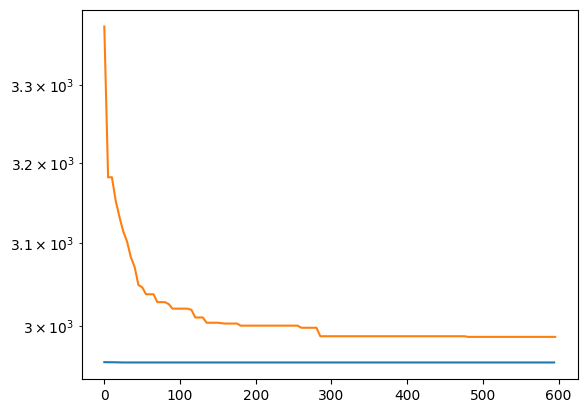

In [38]:
for df in dfs:
    plt.semilogy(df.time[:120], df.objective[:120])
plt.show()

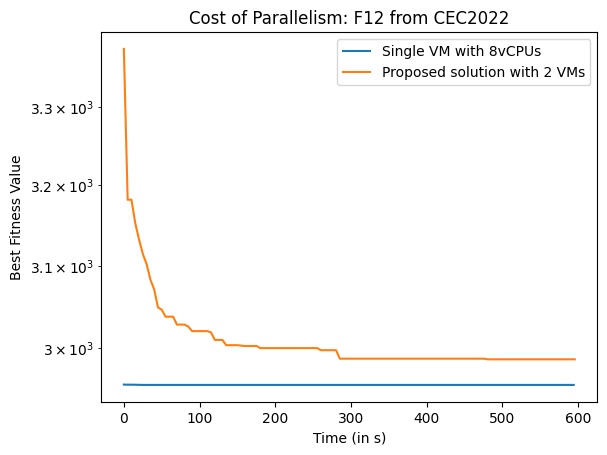

In [43]:
for df in dfs:
    plt.semilogy(df.time[:120], df.objective[:120])
plt.xlabel('Time (in s)')
plt.title('Cost of Parallelism: F12 from CEC2022') 
plt.legend(['Single VM with 8vCPUs', 'Proposed solution with 2 VMs'])
plt.ylabel('Best Fitness Value')
plt.show()

In [46]:
dfs = [
    pd.read_csv(fname, names=['time', 'objective']) for fname in ['./p11_ga/c8_1.csv', './p11_ga/c4_2.csv']
]

In [47]:
dfs[1].head(10)

,time,objective
0,2.496026,29534.6680
1,7.503255,29534.6680
2,12.512013,29534.6680
3,17.518044,29534.6680
4,22.523257,2802.1526
5,27.528093,2639.4485
6,32.532414,2618.6619
7,37.537525,2616.7090
8,42.542826,2615.3457
9,47.548233,2614.2861


In [49]:
dfs[0].time = dfs[0].time - dfs[0].at[0, 'time']
dfs[1].time = dfs[1].time - dfs[1].at[4, 'time']
dfs[1] = dfs[1][4:]

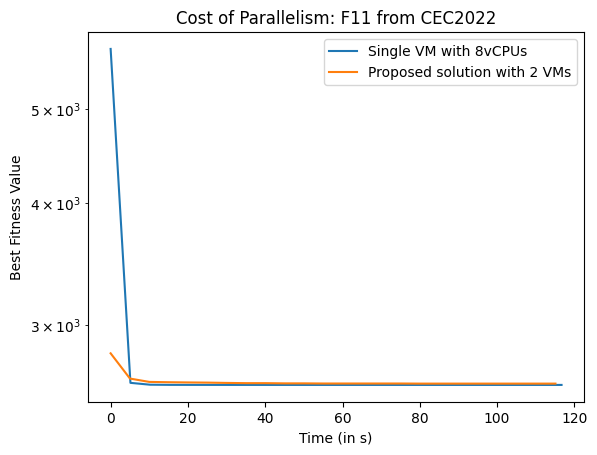

In [52]:
for df in dfs:
    plt.semilogy(df.time[:24], df.objective[:24])
plt.xlabel('Time (in s)')
plt.title('Cost of Parallelism: F11 from CEC2022') 
plt.legend(['Single VM with 8vCPUs', 'Proposed solution with 2 VMs'])
plt.ylabel('Best Fitness Value')
plt.show()

In [53]:
dfs = [
    pd.read_csv(fname, names=['time', 'objective']) for fname in ['./p7_ga_c8_smaller.csv', './p7_ga_c4_alt.csv']
]

In [54]:
dfs[1].head(10)

,time,objective
0,1.997476,20242.2000
1,6.993359,20242.2000
2,12.004600,20242.2000
3,17.012047,20242.2000
4,22.021339,20242.2000
5,27.024953,20242.2000
6,32.030483,6479.8086
7,37.035775,5424.9424
8,42.040148,3994.3025
9,47.045302,3945.8300


In [55]:
dfs[1].time = dfs[1].time - dfs[1].at[5, 'time']
dfs[1] = dfs[1][5:]
dfs[0].time = dfs[0].time - dfs[0].at[0, 'time']

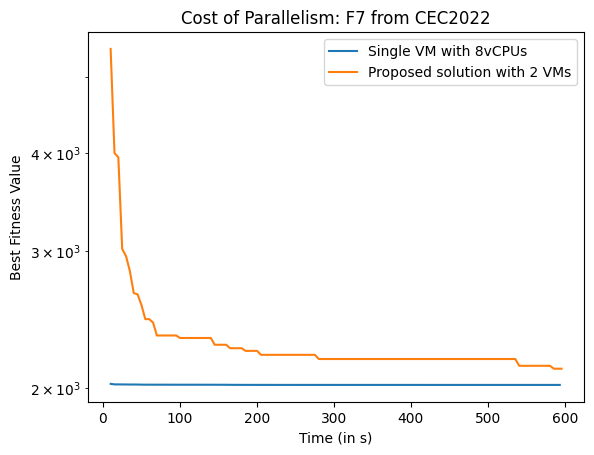

In [59]:
for df in dfs:
    plt.semilogy(df.time[2:120], df.objective[2:120])
plt.xlabel('Time (in s)')
plt.title('Cost of Parallelism: F7 from CEC2022') 
plt.legend(['Single VM with 8vCPUs', 'Proposed solution with 2 VMs'])
plt.ylabel('Best Fitness Value')
plt.show()